In [153]:
#!pip install python-louvain (https://github.com/taynaud/python-louvain/blob/master/README.rst)
# run in Python 3.10.7

In [154]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np

import community.community_louvain as community_louvain
import leidenalg as la
import igraph as ig
from collections import defaultdict

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

# Data Visualization

### True Graph

In [155]:
# Transform train samples into a graph
G = nx.Graph()

# Read the .txt file
with open('email/email-Eu-core.txt', 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()
        G.add_edge(int(node1), int(node2))

# Display the graph info
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))
print("Graph is connected: ", nx.is_connected(G), "\n")

print(f"Components: {list(nx.connected_components(G))}")
print(f"Number of connected components: {nx.number_connected_components(G)}")
L = []
for x in list(nx.connected_components(G)):
    L.append(len(x))
print(f"Number of nodes in each component: {L}")

The number of nodes: 1005
The number of edges: 16706
Graph is connected:  False 

Components: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,

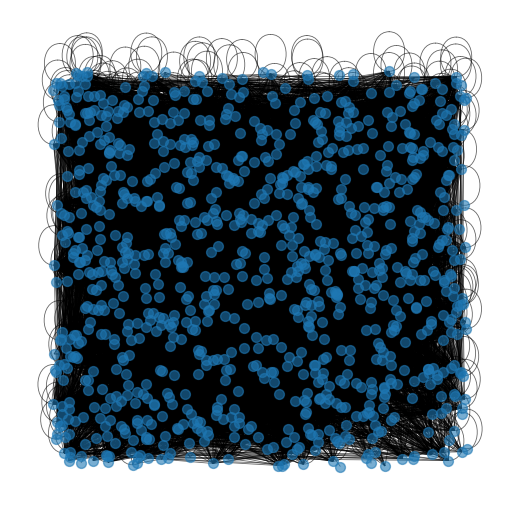

In [156]:
# Plot graph
plt.figure(figsize=(5,5))
pos = nx.random_layout(G, seed=42)
nx.draw(G, with_labels=False,  pos = pos, node_size = 50, alpha = 0.6, width = 0.6)
plt.show()

In [157]:
true_labels = {}
# Read the .txt file
with open('email/email-Eu-core-department-labels.txt', 'r') as file:
    for line in file:
        node, label = line.strip().split()
        true_labels[int(node)] = int(label)
print(true_labels)

{0: 1, 1: 1, 2: 21, 3: 21, 4: 21, 5: 25, 6: 25, 7: 14, 8: 14, 9: 14, 10: 9, 11: 14, 12: 14, 13: 26, 14: 4, 15: 17, 16: 34, 17: 1, 18: 1, 19: 14, 20: 9, 21: 9, 22: 9, 23: 11, 24: 11, 25: 11, 26: 11, 27: 11, 28: 11, 29: 11, 30: 11, 31: 11, 32: 11, 33: 11, 34: 11, 35: 11, 36: 11, 37: 11, 38: 11, 39: 11, 40: 11, 41: 5, 42: 34, 43: 14, 44: 14, 45: 17, 46: 17, 47: 10, 48: 10, 49: 36, 50: 37, 51: 5, 52: 7, 53: 4, 54: 22, 55: 22, 56: 21, 57: 21, 58: 21, 59: 21, 60: 7, 61: 7, 62: 36, 63: 21, 64: 25, 65: 4, 66: 8, 67: 15, 68: 15, 69: 15, 70: 37, 71: 37, 72: 9, 73: 1, 74: 1, 75: 10, 76: 10, 77: 3, 78: 3, 79: 3, 80: 29, 81: 15, 82: 36, 83: 36, 84: 37, 85: 1, 86: 36, 87: 34, 88: 20, 89: 20, 90: 8, 91: 15, 92: 9, 93: 4, 94: 5, 95: 4, 96: 20, 97: 16, 98: 16, 99: 16, 100: 16, 101: 16, 102: 38, 103: 7, 104: 7, 105: 34, 106: 38, 107: 36, 108: 8, 109: 27, 110: 8, 111: 8, 112: 8, 113: 10, 114: 10, 115: 13, 116: 13, 117: 6, 118: 26, 119: 10, 120: 1, 121: 36, 122: 0, 123: 13, 124: 16, 125: 16, 126: 22, 127:

In [158]:
# To see if every node is attributed to one community
assert len(true_labels.keys()) == G.number_of_nodes(), "There are some nodes which don't belong to any community"

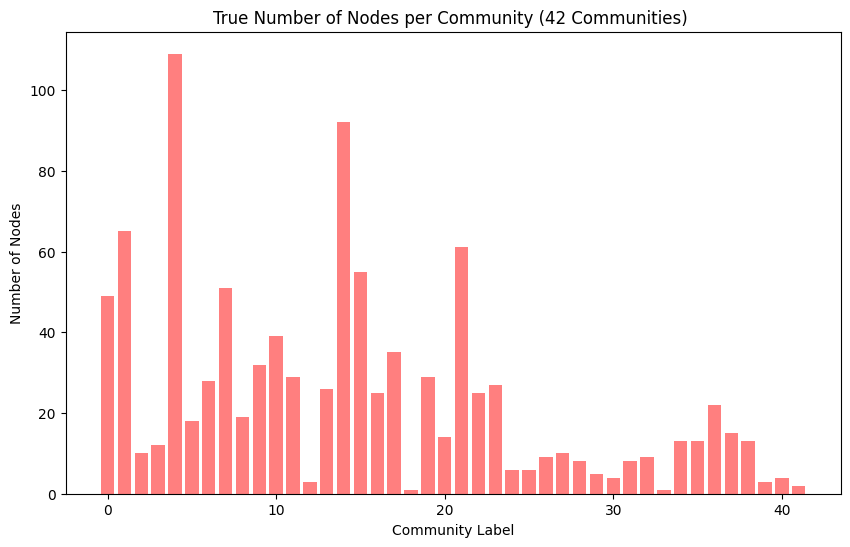

In [185]:
# Extract community labels and the corresponding number of nodes
true_com = defaultdict(int)
for node, com in true_labels.items():
        true_com[com] += 1
        
true_communities = list(true_com.keys())  # Community labels
true_sizes = list(true_com.values())  # Number of nodes in each community

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(true_communities, true_sizes, color='red', alpha=0.5)

# Add labels and title
plt.xlabel('Community Label')
plt.ylabel('Number of Nodes')
plt.title(f'True Number of Nodes per Community ({len(true_com)} Communities) ')

# Display the plot
plt.show()

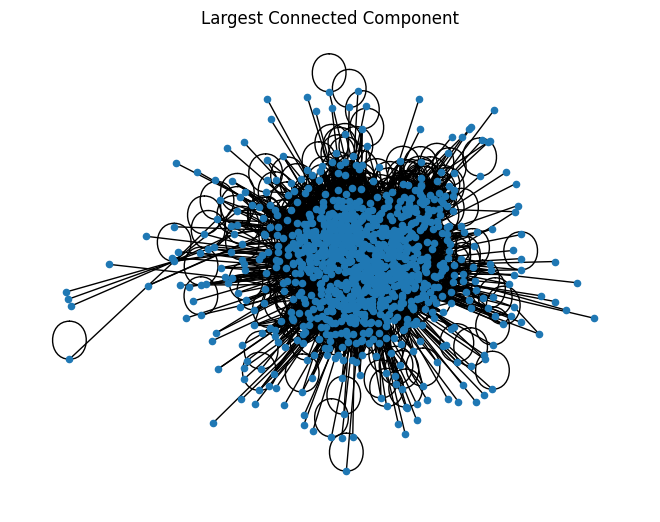

In [186]:
components = list(nx.connected_components(G))

# Get the largest component by size
largest_component = max(components, key=len)

# Create a subgraph of the largest component
largest_subgraph = G.subgraph(largest_component)

# Plot the largest component (optional)
import matplotlib.pyplot as plt
pos = nx.spring_layout(largest_subgraph)
nx.draw(largest_subgraph, pos, with_labels=False, node_size=20, font_size=10)
plt.title("Largest Connected Component")
plt.show()

### Useful functions

In [187]:
def show_boxplot(dict_labels: dict, algo_name: str):
    
    ### Extract community labels and the corresponding number of nodes, for the true labels
    true_com = defaultdict(int)
    for node, com in true_labels.items():
            true_com[com] += 1
            
    true_communities = list(true_com.keys())  # Community labels
    true_sizes = list(true_com.values())  # Number of nodes in each community


    ### Extract community labels and the corresponding number of nodes, for the predicted labels
    count_com = defaultdict(int)
    for node, com in dict_labels.items():
            count_com[com] += 1

    communities = [] # Community labels
    sizes = [] # Number of nodes in each community
    for com in range(max(len(true_com), len(count_com))):
            communities.append(com)
            if com in list(count_com.keys()):
                    sizes.append(count_com[com])
            else:
                    sizes.append(0)

    # Plot the data in louvain
    plt.figure(figsize=(10, 6))
    plt.bar(communities, sizes, alpha=0.5, label=f"{algo_name}")
    plt.bar(true_communities, true_sizes, alpha=0.5, label="True labels")

    # Add labels and title
    plt.xlabel('Community Label')
    plt.ylabel('Number of Nodes')
    plt.title(f'Number of Nodes per Community for {algo_name} ({len(count_com)} Communities)')

    # Display the plot
    plt.legend()
    plt.show()

In [188]:
def scores(dict_labels: dict, algo_name: str):

    true_labels_list = [true_labels[node] for node in G.nodes()]
    dict_labels_list = [dict_labels[node] for node in G.nodes()]

    ari_score = adjusted_rand_score(true_labels_list, dict_labels_list)
    print(f"Adjusted Rand Index (ARI) for {algo_name}: {ari_score:.4f}")

    nmi_score = normalized_mutual_info_score(true_labels_list, dict_labels_list)
    print(f"Normalized Mutual Info (NMI) for {algo_name}: {nmi_score:.4f}")

    s = 0
    for node in G.nodes():
        if dict_labels[node] == true_labels[node]:
            s += 1
    print(f"Accuracy for {algo_name}: {s/len(G.nodes):.4f}")

In [189]:
def align_labels(dict_labels):

    y_true = []
    y_pred = []
    for node in dict_labels:
        y_true.append(true_labels[node])
        y_pred.append(dict_labels[node])

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Use Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize total score
    
    # Create a mapping from predicted label → true label
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    return mapping

## Louvain

In [202]:
start = time.time()

# Apply Louvain algorithm
louvain_partition = community_louvain.best_partition(G)

# Align labels
mapping = align_labels(louvain_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
louvain_labels = {node: mapping[louvain_partition[node]] for node in louvain_partition}
duration = time.time() - start

print(louvain_labels)

{0: 1, 1: 1, 2: 21, 3: 21, 4: 21, 5: 21, 6: 21, 7: 14, 8: 14, 9: 14, 10: 15, 11: 14, 12: 14, 13: 10, 14: 4, 15: 17, 16: 15, 17: 1, 18: 1, 19: 14, 20: 15, 21: 15, 22: 15, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10, 38: 10, 39: 10, 40: 10, 41: 4, 42: 15, 43: 14, 44: 14, 45: 17, 46: 17, 47: 10, 48: 10, 49: 15, 50: 15, 51: 4, 52: 7, 53: 4, 54: 21, 55: 21, 56: 21, 57: 21, 58: 21, 59: 21, 60: 7, 61: 7, 62: 15, 63: 21, 64: 4, 65: 4, 66: 15, 67: 15, 68: 15, 69: 15, 70: 15, 71: 15, 72: 15, 73: 1, 74: 1, 75: 10, 76: 10, 77: 15, 78: 15, 79: 4, 80: 15, 81: 15, 82: 15, 83: 15, 84: 15, 85: 1, 86: 4, 87: 15, 88: 21, 89: 21, 90: 15, 91: 15, 92: 15, 93: 4, 94: 4, 95: 4, 96: 10, 97: 17, 98: 17, 99: 17, 100: 17, 101: 17, 102: 21, 103: 7, 104: 7, 105: 15, 106: 15, 107: 15, 108: 15, 109: 15, 110: 15, 111: 15, 112: 15, 113: 10, 114: 10, 115: 10, 116: 10, 117: 15, 118: 15, 119: 10, 120: 1, 121: 15, 122: 7, 123: 10, 124: 17, 125: 17, 

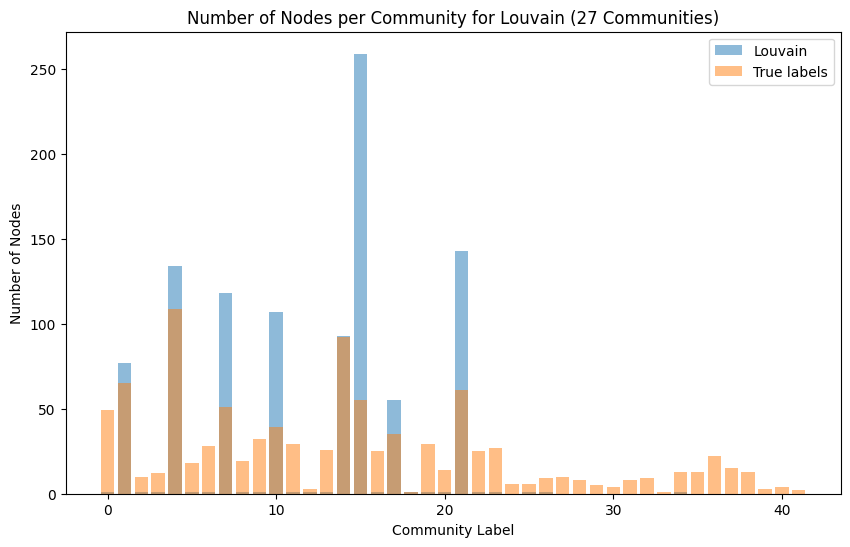

Adjusted Rand Index (ARI) for Louvain: 0.3393
Normalized Mutual Info (NMI) for Louvain: 0.6003
Accuracy for Louvain: 0.4517
Time for Louvain: 0.1797 s


In [203]:
algo_name = "Louvain"

show_boxplot(louvain_labels, algo_name)
scores(louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

## Leiden

In [204]:
# The implemented Leiden needs igraph format
G_ig = ig.Graph.from_networkx(G)
G_ig.vs["name"] = list(G.nodes())

In [206]:
start = time.time()

# Apply Leiden algorithm
partition = la.find_partition(G_ig, la.ModularityVertexPartition)

# Print community assignments
leiden_partition = {node: com for node, com in zip(G.nodes(), partition.membership)}

# Align labels
mapping = align_labels(leiden_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
leiden_labels = {node: mapping[leiden_partition[node]] for node in leiden_partition}
duration = time.time() - start

print(leiden_labels)

{0: 1, 1: 1, 2: 21, 3: 21, 4: 21, 5: 21, 6: 21, 7: 14, 8: 14, 9: 14, 10: 15, 11: 14, 12: 14, 13: 10, 14: 4, 15: 17, 16: 15, 17: 1, 18: 1, 19: 14, 20: 15, 21: 15, 22: 15, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10, 38: 10, 39: 10, 40: 10, 41: 4, 42: 15, 43: 14, 44: 14, 45: 17, 46: 17, 47: 10, 48: 10, 49: 15, 50: 15, 51: 4, 52: 7, 53: 4, 54: 21, 55: 21, 56: 21, 57: 21, 58: 21, 59: 21, 60: 7, 61: 7, 62: 15, 63: 21, 64: 4, 65: 4, 66: 15, 67: 15, 68: 15, 69: 15, 70: 15, 71: 15, 72: 15, 73: 1, 74: 1, 75: 10, 76: 10, 77: 15, 78: 10, 79: 10, 80: 15, 81: 15, 82: 15, 83: 15, 84: 15, 85: 1, 86: 4, 87: 15, 88: 21, 89: 21, 90: 15, 91: 15, 92: 15, 93: 4, 94: 4, 95: 4, 96: 10, 97: 17, 98: 17, 99: 17, 100: 17, 101: 17, 102: 21, 103: 7, 104: 7, 105: 15, 106: 15, 107: 15, 108: 15, 109: 15, 110: 15, 111: 15, 112: 15, 113: 10, 114: 10, 115: 10, 116: 10, 117: 1, 118: 15, 119: 10, 120: 1, 121: 15, 122: 7, 123: 10, 124: 17, 125: 17, 

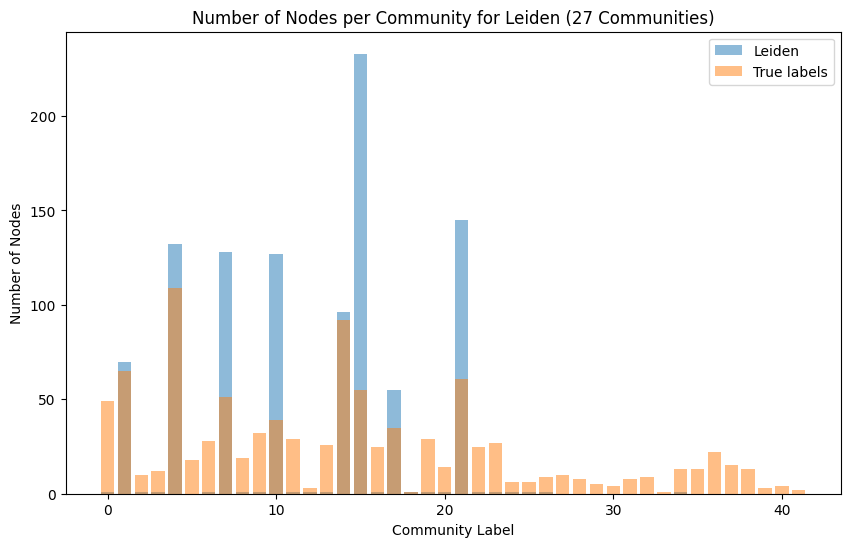

Adjusted Rand Index (ARI) for Leiden: 0.3488
Normalized Mutual Info (NMI) for Leiden: 0.5975
Accuracy for Leiden: 0.4498
Time for Leiden: 0.0760 s


In [207]:
algo_name = "Leiden"

show_boxplot(leiden_labels, algo_name)
scores(leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

# Hierarchical Louvain

In [ ]:
def recursive_louvain(graph, level=0, max_depth=2):
    partition = community_louvain.best_partition(graph)
    communities = {}

    for node, comm_id in partition.items():
        communities.setdefault(comm_id, []).append(node)

    hierarchy = {}
    for comm_id, nodes in communities.items():
        subgraph = G.subgraph(nodes)
        hierarchy[comm_id] = {
            'level': level,
            'nodes': nodes,
            'subcommunities': None
        }
        # Recursive step
        if level + 1 < max_depth and len(nodes) > 3:
            sub_hierarchy = recursive_louvain(subgraph, level + 1, max_depth)
            hierarchy[comm_id]['subcommunities'] = sub_hierarchy

    return hierarchy


def flatten_community_tree(tree, path_prefix=()):
    flat_labels = {}

    for comm_id, info in tree.items():
        path = path_prefix + (comm_id,)
        for node in info['nodes']:
            flat_labels[node] = path

        if info['subcommunities'] is not None:
            sub_flat = flatten_community_tree(info['subcommunities'], path)
            flat_labels.update(sub_flat)

    return flat_labels

In [242]:
start = time.time()

# Remark: the hierarchical algorithm converges to a stable structure with subcommunities
depth = 2

# Run and flatten
community_tree = recursive_louvain(G, max_depth=depth)
hierar_louvain_partition = flatten_community_tree(community_tree)

# To map the tuple communities to int labels
L_old_labels = list(set(hierar_louvain_partition.values()))
tuple2int = {}

i = 0
for x in L_old_labels:
    tuple2int[x] = i
    i+=1

for node in hierar_louvain_partition.keys():
    hierar_louvain_partition[node] = tuple2int[hierar_louvain_partition[node]]

# Align labels
mapping = align_labels(hierar_louvain_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
hierar_louvain_labels = {node: mapping[hierar_louvain_partition[node]] for node in hierar_louvain_partition}
duration = time.time() - start

print(hierar_louvain_labels)

{0: 26, 1: 1, 17: 1, 18: 26, 73: 39, 74: 1, 85: 1, 120: 26, 146: 26, 166: 26, 177: 51, 215: 39, 218: 1, 219: 1, 220: 51, 221: 1, 222: 36, 223: 39, 224: 1, 225: 39, 226: 1, 227: 36, 228: 36, 248: 39, 268: 39, 297: 51, 301: 26, 307: 1, 309: 51, 310: 1, 311: 39, 312: 1, 313: 1, 314: 1, 315: 36, 316: 51, 317: 1, 330: 39, 331: 39, 341: 51, 435: 24, 459: 39, 468: 1, 507: 1, 519: 36, 537: 36, 560: 1, 596: 26, 613: 24, 614: 24, 616: 24, 629: 51, 650: 39, 695: 36, 696: 1, 730: 26, 742: 24, 745: 60, 756: 39, 759: 39, 764: 1, 775: 1, 793: 24, 857: 26, 872: 1, 882: 26, 905: 51, 920: 24, 979: 60, 1002: 1, 2: 21, 3: 21, 4: 21, 5: 25, 6: 21, 54: 22, 55: 22, 56: 21, 57: 22, 58: 21, 59: 21, 63: 21, 88: 20, 89: 20, 102: 25, 126: 22, 131: 22, 132: 22, 137: 21, 138: 21, 158: 19, 159: 19, 174: 21, 175: 21, 192: 21, 193: 21, 194: 21, 195: 21, 208: 22, 209: 19, 210: 19, 211: 22, 233: 19, 234: 19, 235: 19, 236: 19, 237: 19, 238: 19, 239: 19, 240: 19, 241: 19, 242: 19, 243: 19, 244: 19, 252: 20, 271: 22, 281: 

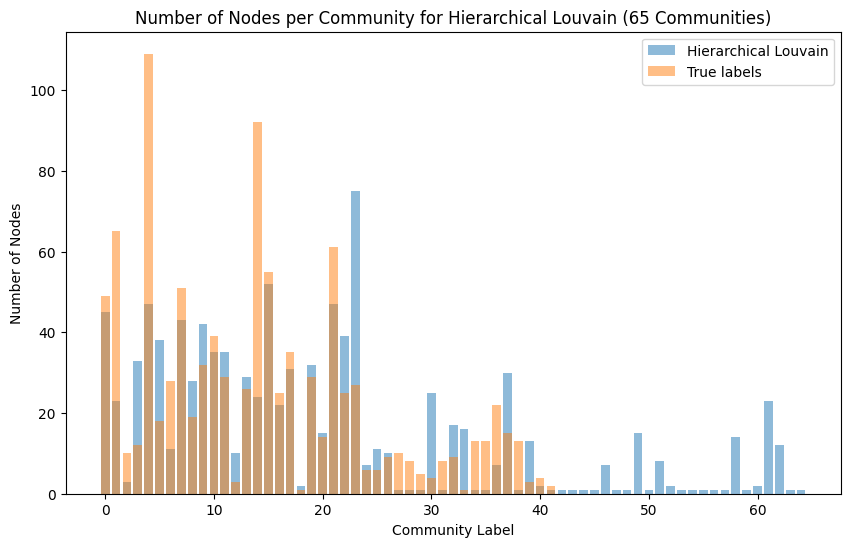

Adjusted Rand Index (ARI) for Hierarchical Louvain: 0.4407
Normalized Mutual Info (NMI) for Hierarchical Louvain: 0.7107
Accuracy for Hierarchical Louvain: 0.5592
Time for Hierarchical Louvain: 0.2594 s


In [243]:
algo_name = "Hierarchical Louvain"

show_boxplot(hierar_louvain_labels, algo_name)
scores(hierar_louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

# Hierarchical Leiden

In [252]:
def recursive_leiden(graph, level=0, max_depth=3):
    
    partition = la.find_partition(
        graph,
        la.ModularityVertexPartition) # CPMVertexPartition, ModularityVertexPartition
    
    hierarchy = {}

    for i, community in enumerate(partition):

        subgraph = graph.subgraph(community)
        hierarchy[i] = {
            'level': level,
            'nodes': community,
            'subcommunities': None
        }

        if level + 1 < max_depth and len(community) > 3:
            sub_hierarchy = recursive_leiden(subgraph, level + 1, max_depth)
            hierarchy[i]['subcommunities'] = sub_hierarchy

    return hierarchy

def flatten_community_tree(tree, path_prefix=()):
    flat_labels = {}

    for comm_id, info in tree.items():
        path = path_prefix + (comm_id,)
        for node in info['nodes']:
            flat_labels[node] = path

        if info['subcommunities'] is not None:
            sub_flat = flatten_community_tree(info['subcommunities'], path)
            flat_labels.update(sub_flat)

    return flat_labels


In [253]:
# The implemented Leiden needs igraph format
G_ig = ig.Graph.from_networkx(G)

In [254]:
start = time.time()

# Remark: the hierarchical algorithm converges to a stable structure with subcommunities
depth = 5

# Run and flatten
community_tree = recursive_leiden(G_ig, max_depth=depth)
hierar_leiden_partition = flatten_community_tree(community_tree)

# To map the tuple communities to int labels
L_old_labels = list(set(hierar_leiden_partition.values()))
tuple2int = {}

i = 0
for x in L_old_labels:
    tuple2int[x] = i
    i+=1

for node in hierar_leiden_partition.keys():
    hierar_leiden_partition[node] = tuple2int[hierar_leiden_partition[node]]

# Align labels
mapping = align_labels(hierar_leiden_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
hierar_leiden_labels = {node: mapping[hierar_leiden_partition[node]] for node in hierar_leiden_partition}
duration = time.time() - start

print(hierar_leiden_labels)

{0: 60, 1: 54, 10: 9, 16: 34, 17: 61, 18: 34, 20: 34, 21: 9, 22: 33, 42: 22, 49: 11, 50: 22, 62: 36, 66: 29, 67: 3, 68: 29, 69: 29, 70: 37, 71: 37, 72: 37, 73: 37, 74: 36, 77: 37, 78: 29, 79: 3, 80: 29, 81: 36, 82: 37, 83: 36, 84: 37, 85: 3, 87: 5, 90: 36, 91: 29, 92: 5, 105: 67, 106: 49, 107: 46, 108: 46, 109: 49, 110: 67, 111: 8, 112: 8, 117: 6, 118: 35, 120: 28, 121: 35, 127: 35, 142: 35, 143: 35, 144: 74, 145: 35, 146: 6, 147: 66, 152: 66, 153: 27, 154: 24, 155: 27, 160: 27, 162: 66, 163: 24, 166: 0, 173: 0, 184: 24, 186: 24, 187: 27, 188: 66, 189: 66, 190: 53, 212: 76, 215: 1, 217: 76, 218: 1, 219: 1, 221: 1, 222: 40, 223: 48, 224: 48, 225: 40, 226: 76, 227: 1, 228: 1, 230: 23, 248: 23, 249: 48, 253: 23, 254: 40, 255: 70, 256: 76, 258: 1, 259: 76, 260: 1, 268: 1, 279: 23, 282: 40, 287: 76, 288: 1, 297: 1, 298: 48, 299: 18, 300: 18, 306: 15, 307: 15, 309: 15, 310: 15, 311: 15, 312: 15, 313: 15, 314: 15, 315: 15, 316: 15, 317: 15, 325: 15, 326: 15, 327: 15, 328: 15, 329: 15, 340: 15

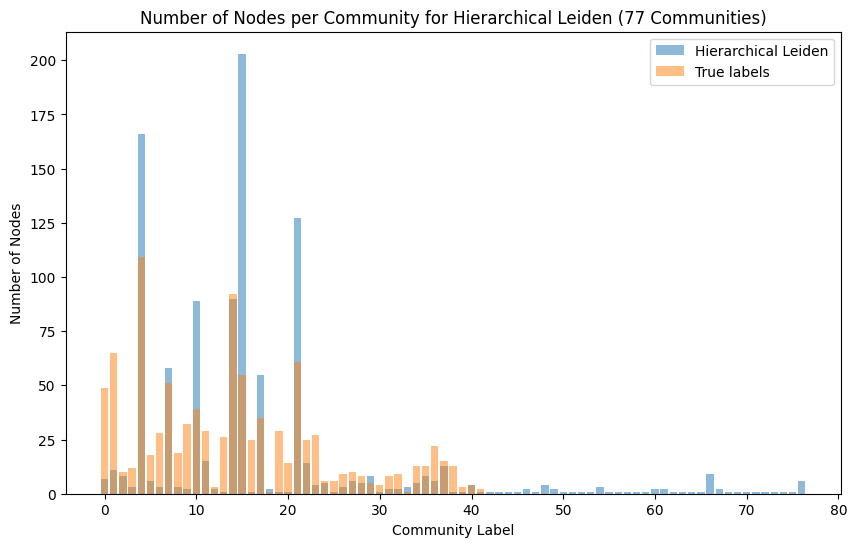

Adjusted Rand Index (ARI) for Hierarchical Leiden: 0.3050
Normalized Mutual Info (NMI) for Hierarchical Leiden: 0.5515
Accuracy for Hierarchical Leiden: 0.4080
Time for Hierarchical Leiden: 0.1945 s


In [255]:
algo_name = "Hierarchical Leiden"

show_boxplot(hierar_leiden_labels, algo_name)
scores(hierar_leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")